In [82]:
import numpy as np  # import libraries
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import math

# Classification of MNIST Digits with SVD Decomposition.
The task is to learn the classification of MNIST digits by using SVD decomposition.
Remember that, Given a matrix $X ∈ \mathbb{R}^{m×n}$ and its SVD decomposition $X = USV$ T we can prove that
an orthogonal base for the space of the columns is given by the first p columns of the matrix U, where
$p = rank(X)$ is equal to the number of non-zero singular values of $A$.

We will make use of the space of the columns defined by the U matrix and the following Theorem:

**Theorem 1.** *Let’s consider W a subspace of R
n where dim $W = s$ and ${w1, . . . , ws}$ an orthogonal base of
$W$. Given a generic y ∈ R
n we have that the projection $y^⊥$ of $y$ onto $W$ has the following form:*

$ y^\perp = \frac{y\cdot w_1}{w_1\cdot w_1} w_1 + ... + \frac{y\cdot w_c}{w_c\cdot w_c}w_s $

**Corollary 1.1.** *If X ∈ R
m×n is a given matrix with SVD decomposition $X = USV T$, since the $p = rank(X)$ is the dimension of the space defined by the columns of X and the columns of $U$, ${u1, . . . , up}$ are an
orthonormal basis for that space, the projection of an n-dimensional vector y on this space can be easily
computed as:*

$$ y^\perp = U(U^T y) $$

Thus, consider a binary classification problem, where we want to classificate if a given digit of dimension
m × n represents the number $3$ or the number $4$. We will call refer to the class of the number $3$ as $C_1$, and
to the class of the number $4$ as $C_2$. Suppose that $s_1$ is the number of elements in $C_1$, while $s_2$ is the number
of elements in $C_2$.
If $X_1 ∈ \mathbb{R}^{mn×s1}$ is the matrix such that its columns are a flatten version of each digit in $C_1$, $X_2 ∈ \mathbb{R}^{mn×s2}$
is the matrix such that its columns are a flatten version of each digit in $C_2$, and consider

$$ X_1 = U_1S_1V_1^T $$
$$ X_2 = U_2S_2V_2^T $$

the SVD decomposition of the two matrices

If $y$ in $\mathbb{R}^{mn}$ is a new, unknown digit, we can classify it by first flatten it to a vector of $\mathbb{R}^{mn}$, then we
can project it to the spaces of $X_0$ and $X_1$ and call them

$$ y_1^\perp = U_1(U_1^T y) $$
$$ y_2^\perp = U_2(U_2^T y) $$

Thus, y will be classified as C1 if $||y − y^⊥_1||_2 < ||y − y^⊥_2|_2$ and vice versa will be classified as C2 if $||y − y^⊥_2||_2 < ||y − y^⊥_1|_2$. We want to implement this idea on Python.


# 1. BINARY CLASSIFICATOR
 First, we will implement the binary classification algorithm for the digits 3 and 4 of
MNIST following the ideas explained above.


- Load the MNIST dataset contained in *./data/MNIST.mat* with the function scipy.io.loadmat.
This dataset, which is loaded in the form of a $256 ×1707$ matrix $X$, contains the flattened version
of $1707$ $16 × 16$ grayscale handwritten digits. Moreover, from the same file it is possible to load
a vector I of length $1707$ such that the i-th element of $I$ is the true digit represented by the i-th
image of $X$

In [83]:
DATA=scipy.io.loadmat('data/MNIST.mat')     #import the data

X=DATA['X']     # split the data from the labels
I=DATA['I']

data=np.concatenate([X,I],0).T      # shuffle the data
np.random.shuffle(data)             # shuffle is an algorithm in place !

X=data.T[:-1]
I=data.T[-1]

- Visualize a bunch of datapoints of $X$ with the function plt.imshow.

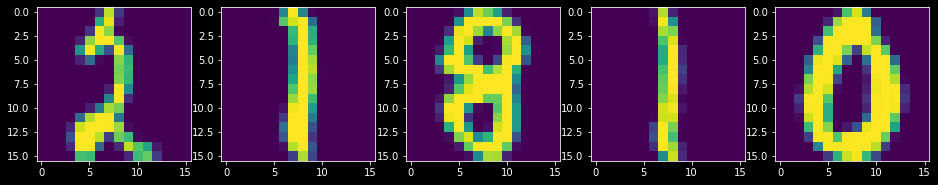

In [84]:
plots_per_row=5

plt.figure(figsize=(16, 4 ))

for i in range(plots_per_row):
    
    plt.subplot(1,plots_per_row,i+1)

    img =  X[:,np.random.randint(len(X))]           # select a random image
    plt.imshow( np.reshape( img , (16,16) ) )       # reshape and show

- Extract from $X$ those columns that corresponds to digits $3$ or $4$. Those digits represents the
classes $C_1$ and $C_2$ defined above.

I divide all the classes and put them in a dictionary since I'm goin to need them later

In [85]:
digits = [3, 4]

idx=np.zeros(I.shape, dtype=bool)

for d in digits:
    idx+=I==d 

X=X[:, idx]
I=I[idx]

- Split the obtained dataset in training and testing. From now on, we will only consider the training
set. The test set will be only used at the end of the exercise to test the algorithm.



In [86]:
train_percentage=0.10       # low in order to have some errors

n=int(X.shape[1]*train_percentage)      #calculate the number of training samples

X_train = X[:,:n]
X_test = X[:,n:]

I_train = I[:n]
I_test = I[n:]

- Create the matrices $X_1$ and $X_2$ defined above from X

In [87]:
X1 = X_train[:, np.squeeze(I_train==digits[0])]
X2 = X_train[:, np.squeeze(I_train==digits[1])]

- Compute the SVD decomposition of $X_1$ and $X_2$ with *np.linalg.svd(matrix, full matrices=False)*
and denote the U-part of the two decompositions as $U_1$ and $U_2$.

In [88]:
U1, _, _ =np.linalg.svd(X1, full_matrices=False)
U2, _, _ =np.linalg.svd(X2, full_matrices=False)

- Take an unknown digit y from the test set, and compute $y^⊥_1 = U_1(U^T_1y)$ and $y^⊥_2 = U_2(U^T_2y)$.

In [89]:
i=np.random.randint(X_test.shape[1])

y=X_test[:,i]
y=np.expand_dims(y,1)

u1=np.expand_dims(U1[:,0],1)
u2=np.expand_dims(U2[:,0],1)

y_p1= u1 @ u1.T @ y
y_p2= u2 @ u2.T @ y

- Compute the distances $d_1 = ||y − y^⊥_1||_2$ and $d_2 = ||y − y^⊥_2||_2$ and classify y to $C1$ if $d_1 < d_2$ and
to $C_2$ if $d_2 < d_1$.

In [90]:
d1=np.linalg.norm(y-y_p1)
d2=np.linalg.norm(y-y_p2)

if d1<d2:
    print("class C1: it's a 3")
else:
    print("class C2: it's a 4")

print(f"Real class: {int(I_test[i])}")

class C1: it's a 3
Real class: 3


- Repeat the experiment for different values of $y$ in the test set. Compute the misclassification number for this algorithm.

In [91]:
for i in range(5):
    i=np.random.randint(X_test.shape[1])

    y=X_test[:,i]
    y=np.expand_dims(y,1)

    u1=np.expand_dims(U1[:,0],1)
    u2=np.expand_dims(U2[:,0],1)

    y_p1= u1 @ u1.T @ y
    y_p2= u2 @ u2.T @ y

    d1=np.linalg.norm(y-y_p1)
    d2=np.linalg.norm(y-y_p2)

    if d1<d2:
        print(f"Predicted class: 3    | Real class: {int(I_test[i])}")
    else:
        print(f"Predicted class: 4    | Real class: {int(I_test[i])}")
    print(f"d1: {d1} | d2: {d2}")
    print()

Predicted class: 4    | Real class: 4
d1: 5.710626974652996 | d2: 5.077501889149131

Predicted class: 4    | Real class: 4
d1: 7.188532658395256 | d2: 5.22508816106282

Predicted class: 3    | Real class: 3
d1: 3.789458579080526 | d2: 6.27757550659447

Predicted class: 4    | Real class: 4
d1: 3.569997506158141 | d2: 3.27470117144113

Predicted class: 3    | Real class: 3
d1: 4.3024044917181525 | d2: 5.595639706696324



I calculate the accuracy on the test set

In [92]:
l=X_test.shape[1]

U=np.concatenate([np.expand_dims(u1,0),np.expand_dims(u2,0)],0)


projections = U @ np.transpose(U, axes=[0,2,1]) @ X_test

distances = np.linalg.norm(projections - np.expand_dims(X_test,0), axis=1)

classification=np.argmin(distances,0)

predictions=np.choose(classification,digits)

accuracy=sum((predictions==I_test))/l

print(f"accuracy:    {accuracy*100} %")

accuracy:    98.68421052631578 %


We can show the image and the singular images onto which we are projecting to try to understand why it could be misclassificating

d1: 5.555595774231273 | d2: 5.841137966172354


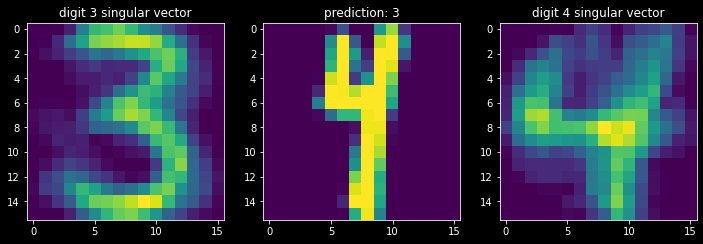

In [93]:
errors=np.where(predictions!=I_test)
img=X_test[:,errors[0][0]]

plt.figure(figsize=(12, 4 ))


plt.subplot(1,3,1)
plt.title(f"digit {digits[0]} singular vector")
plt.imshow( np.reshape( -u1 , (16,16) ) )

plt.subplot(1,3,2)
plt.title(f"prediction: {predictions[errors[0][0]]}")
plt.imshow( np.reshape( img , (16,16) ) )

plt.subplot(1,3,3)
plt.title(f"digit {digits[1]} singular vector")
plt.imshow( np.reshape( -u2 , (16,16) ) )

print(f"d1: {distances[0,errors[0][0]]} | d2: {distances[1,errors[0][0]]}")

We can see that our singular vectors are pretty blurry, and if the image we are tryig to classify is particularly deformed our classificator can misclassify it.

---
- Repeat the experiment for different digits other than 3 or 4. Is there a relationship between the
visual similarity of the digits and the classification error?


In order to obtain more complete results we are going to test exery possible pair of digits, in order to better understand the overall behaviour. 

Since the accuracy of the binary classification was extremely high, we are also going to test the classificator decreasing the number of training samples, to see how much we can lower the training data (and also the training cost with it), before losing significant performance.

Also, since the data is not equally distributed between the 10 digits we can choose different approaches to split the data in training and test set:

1. splitting the data without considering the classes (as we did in the previous example): this approach has the downside that potentially the model could not learn properly the minorities;

2. splitting every class proportionally between train and test: in this way we kind of insert the concept of prior in the model, which (in general, in this case we didn't takle the whole optimization problem) will optimize it's parameters knowing the relative probability of having each class; if the distribution of the samples doesn't match the real distribution this could be an error;

3. assigning the same number of examples to the training set for every class: with this approach we are limited by the class with less data, and we would have nearly no data to test it on

4. over sampling the minoriries and data augmentation (see also SMOTE): advanced, not always straightforward

We are going to go with the second option, not much for accounting for the prior, as we know that the digit should have the same probability of occurring, but more for having a proportional part of each class in the test set.

In [94]:
X=DATA['X']
I=DATA['I']

C=pd.Categorical(np.squeeze(I)).categories      #extract the categories

X_divided={}    # initialize empry dictionary


for c in C:
    X_divided[c]=X[ :, np.reshape(I==c,-1) ]    # split the classes

In [95]:
percentages=[95,90,80,60,40,20,10,5,2,1,0.5,0.2]

accuracies=np.empty((len(percentages),len(C)))

cross_error=np.empty((len(percentages),len(C),len(C)))

for n_p, p in enumerate(percentages):

    X_v=np.empty((len(C),X.shape[0]))     # inizialize matrix to put the principal sigular vectors

    n=np.empty((len(C),),dtype=np.int64)    # inizialize vector to put number of training examples


    for c in C:     # calculate the sigular vectors

        X_divided[c]=X_divided[c].T         # shuffle the data
        np.random.shuffle(X_divided[c])
        X_divided[c]=X_divided[c].T

        n[c]=math.ceil(X_divided[c].shape[1]*p*0.01)    #calculate the size of the train set

        X_train=X_divided[c][:,:n[c]]       # slice the matrix

        U,S,V =np.linalg.svd(X_train, full_matrices=False)   # compute SVD

        X_v[c]=U[:,0]       # save principal left singular vector
    

    
    X_v=np.expand_dims(X_v,2)

    for c in C:     # calculate projections of the test sets on all the subspaces

        X_test=X_divided[c][:,n[c]:]
        
        l=X_test.shape[1]
        
        projections = X_v @ np.transpose(X_v, axes=[0,2,1]) @ X_test
        
        distances = np.linalg.norm(projections - np.expand_dims(X_test,0), axis=1)

        dc=np.expand_dims(distances[c],0)

        error=0

        for i in range(len(C)):
            
            if i==c:
                cross_error[n_p,c,i]=1
                continue
            
            di=np.expand_dims(distances[i],0)

            d=np.concatenate([dc,di],0)     # classify (should be 1s)

            classification=np.argmin(d,0)
            
            err=sum(classification)

            cross_error[n_p,c,i]=err/l

            error+=err

        accuracies[n_p,c]=1-error/l/(len(C)-1)


We for this test didn't implement a K-fold validation setup (it would have been a considerable increase of the number of iterations), but since we shuflled the data at every iteration, running the algorithm multiple times we should roughly get an idea of the behavior of the model.

Let's start by plotting the Accuracy over the number of training samples used.

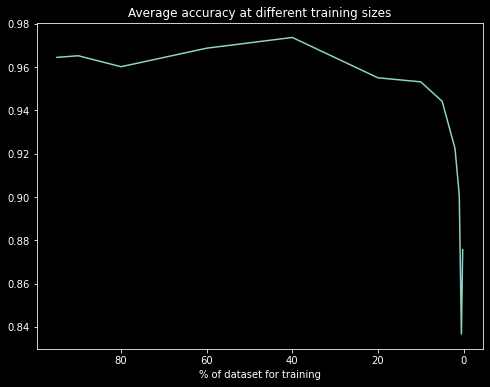

In [96]:
plt.figure(figsize=(8, 6 ))
plt.title('Average accuracy at different training sizes')
plt.plot(percentages,np.mean(accuracies,1))
plt.xlabel('% of dataset for training')
plt.gca().invert_xaxis()

As we can see from the graph the predictor performs quite well even with a smaller dataset, getting (approximately) around 85% accuracy even if trained with less than 1% of the data.

We can then procede plotting the average error for every possible pair of values

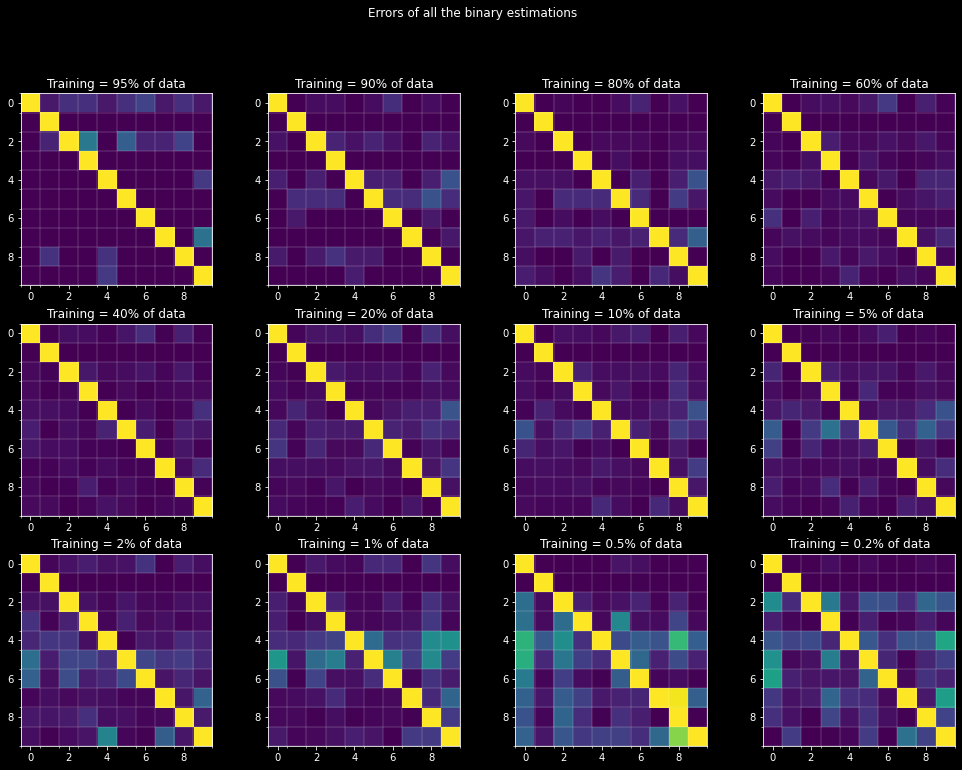

In [97]:
plots_per_row=4

plt.figure(figsize=(17, 4*math.ceil(len(cross_error)/plots_per_row) ))
plt.suptitle('Errors of all the binary estimations')
for i in range(len(cross_error)):
    
    plt.subplot(math.ceil(len(cross_error)/plots_per_row),4,i+1)
    plt.title(f"Training = {percentages[i]}% of data")


    im = plt.imshow(cross_error[i],
                    interpolation='none', vmin=0, vmax=1, aspect='equal')

    ax = plt.gca()

    # Minor ticks
    ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=0.2)

In this plot the line number is the real digit.

We tested every digit against all the other digits and plotted the error in these images. The higher the error the lighter the pixel (we plotted 1-Accuracy of the classification on that pair)

Of course we didn't classify a class against itself, so we set the values of the diagonal to default to 1 (to distinguish it from the others)

<br>

As we can see the are no particulart pairs that tend to be misclassified more than the others, sometimes we get a bad estimate of the singular vector so we get nearly a whole line misclassified, but is more due to the fact that we are randomly sampling a small portion to be the training set than actual correlation of the inputs.

---

# 2. MULTI CLASS CLASSIFICATOR

The extension of this idea to the multiple classification task is trivial. Indeed, if we have more than
2 classes (say, $k$ different classes) $C_1, . . . , C_k$, we just need to repeat the same procedure as before for
each matrix X1, . . . , Xk to obtain the distances $d_1, . . . , d_k$. Then, the new digit y will be classified as $C_i$ if $d_i$
is lower that dj for each $j = 1, . . . , k$.

The framework done on the last example can be easily adapted to the multi classification case, we just need to classify taking the smallest distance instead of considering pair of vectors.

In [98]:
percentages_tot=[95,90,80,60,40,20,10,5,2,1,0.5,0.2]

accuracies_tot=np.empty((len(percentages_tot)))

cross_error_tot=np.empty((len(percentages_tot),len(C),len(C)))

X_v=np.empty((len(percentages_tot),len(C),X.shape[0]))     # inizialize matrix to put the principal sigular vectors

for n_p, p in enumerate(percentages_tot):


    n=np.empty((len(C),),dtype=np.int64)    # inizialize vector to put number of training examples


    for c in C:     # calculate the sigular vectors

        X_divided[c]=X_divided[c].T         # shuffle the data
        np.random.shuffle(X_divided[c])
        X_divided[c]=X_divided[c].T

        n[c]=math.ceil(X_divided[c].shape[1]*p*0.01)    #calculate the size of the train set

        X_train=X_divided[c][:,:n[c]]       # slice the matrix

        U,S,V =np.linalg.svd(X_train, full_matrices=False)   # compute SVD

        X_v[n_p][c]=U[:,0]       # save principal left singular vector
    

    
    Xv=np.expand_dims(X_v[n_p],2)

    for c in C:     # calculate projections of the test sets on all the subspaces

        X_test=X_divided[c][:,n[c]:]
        
        l=X_test.shape[1]
        
        projections = Xv @ np.transpose(Xv, axes=[0,2,1]) @ X_test
        
        distances = np.linalg.norm(projections - np.expand_dims(X_test,0), axis=1)

        classification=np.argmin(distances,0)

        for i in range(len(C)):
            
            tot=sum(classification==i)
            cross_error_tot[n_p,c,i]=tot/l

            if i==c:
                accuracies_tot[n_p]=tot/l
            

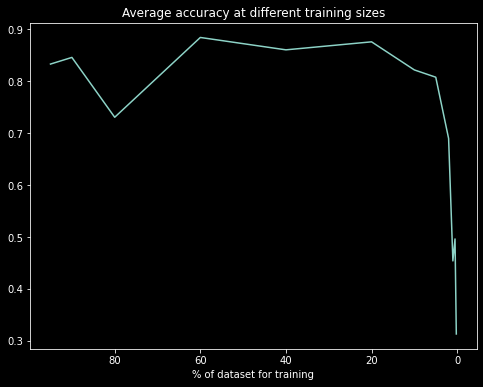

In [99]:
plt.figure(figsize=(8, 6 ))
plt.title('Average accuracy at different training sizes')
plt.plot(percentages_tot,accuracies_tot)
plt.xlabel('% of dataset for training')
plt.gca().invert_xaxis()

As we can see from this plot classifying between more than 2 classes is harder than the binary case; this is also due to the fact that increasing the number of classes (and therefore the number of singular vectors needed), we are decreasing the space between two adiacent singular vectors, making it easier to misclassify an image

(12, 10, 10)


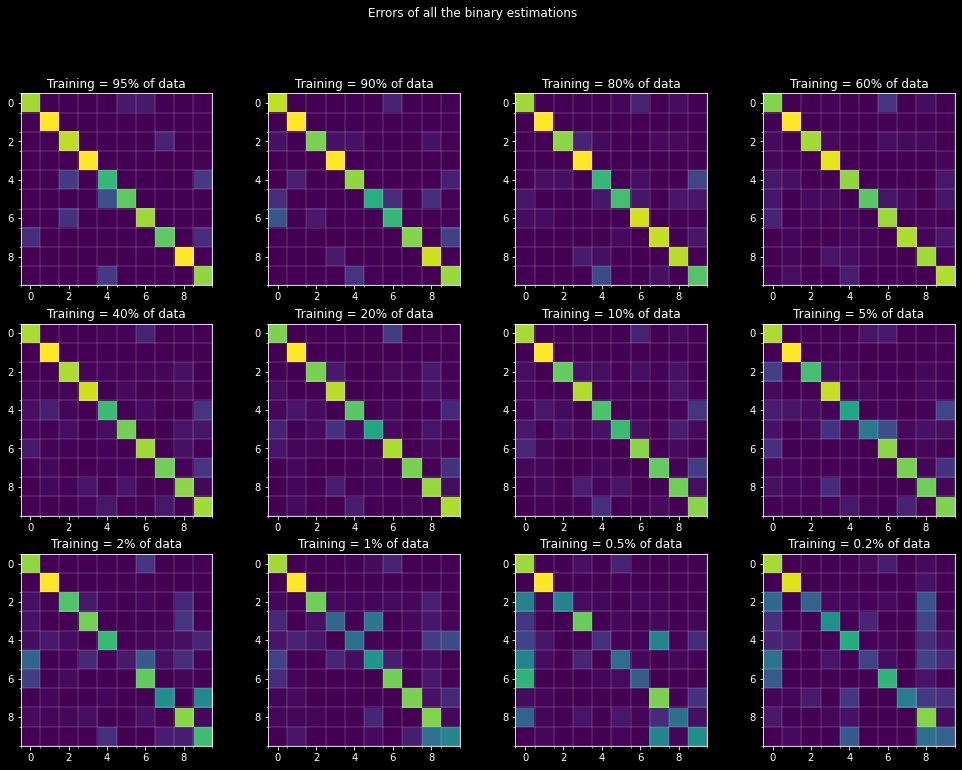

In [100]:
plots_per_row=4
print(cross_error_tot.shape)

plt.figure(figsize=(17, 4*math.ceil(len(cross_error_tot)/plots_per_row) ))
plt.suptitle('Errors of all the binary estimations')
for i in range(len(cross_error_tot)):
    
    plt.subplot( math.ceil(len(cross_error_tot)/plots_per_row),4,i+1)
    plt.title(f"Training = {percentages_tot[i]}% of data")


    im = plt.imshow(cross_error_tot[i],
                    interpolation='none', vmin=0, vmax=1, aspect='equal')

    ax = plt.gca()

    # Minor ticks
    ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=0.2)

As in the previous case from the error matrix there is no evident correlarion between the classes and the errors, it's pretty much stocastic.

Just for reference we can plot the singular vectors.

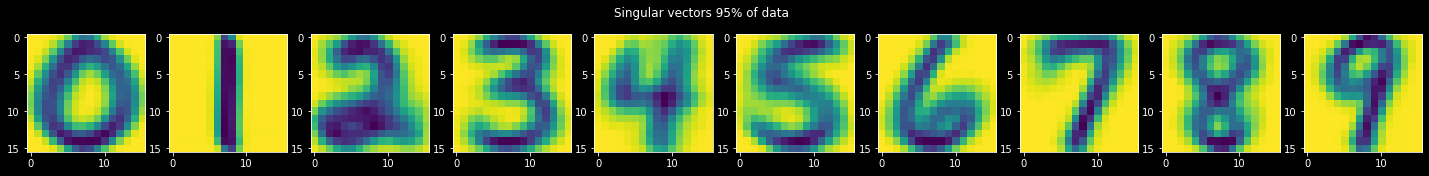

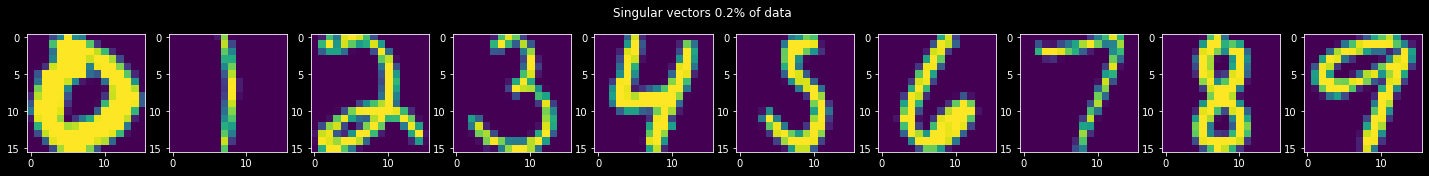

In [101]:
plt.figure(figsize=(25, 2.5 ))
plt.suptitle(f"Singular vectors {percentages[0]}% of data")
for i in range(len(X_v[0])):
    plt.subplot(1,10,i+1)
    plt.imshow( np.reshape( np.squeeze(X_v[0][i]).T , (16,16) ) )

plt.figure(figsize=(25, 2.5 ))
plt.suptitle(f"Singular vectors {percentages[-1]}% of data")
for i in range(len(X_v[-1])):
    plt.subplot(1,10,i+1)
    plt.imshow( np.reshape( np.squeeze(X_v[-1][i]).T , (16,16) ) )